# EDA

This notebook focuses on conducting general exploratory data analysis (EDA). To ensure smooth execution, several libraries need to be loaded beforehand. Additionally, specific functions required for the analysis are available in the nlp_functions.py file, which should be located in the same directory as this notebook. The dataset utilized in this analysis is called reddit_train, comprising 80% of the data extracted from the Reddit API.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import wordnet, stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [2]:
from nlp_functions import nlp_random_search_modeler, lemmatize_text, stem_text, custom_lemmatize, pos_lemmatizer, text_feature_engineering

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# While importing the data, I'm also shuffling the rows to see both subreddits in the mix.
data = pd.read_csv('../data/reddit_train.csv').sample(frac=1.0, random_state=245) 
data.head()

,subreddit,full_text
4615,1,are student loans ever better than paying up f...
2299,1,contractor ghosted us after home repair was do...
8034,0,i just decentralized the entire $1.4 trillion ...
7682,0,1m treasury declines to 3.4% today: discussion...
5622,1,how should i invest my roth ira? \n\ni'm 28 ye...


In [5]:
data.shape

(9460, 2)

In [6]:
data['subreddit'].value_counts()

1    5915
0    3545
Name: subreddit, dtype: int64

I would like to express my gratitude for the valuable insights and techniques shared in Harsh Singh's Kaggle post titled [Complete Guide to EDA on Text Data](https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data). These ideas and methods have greatly contributed to the analysis presented below.

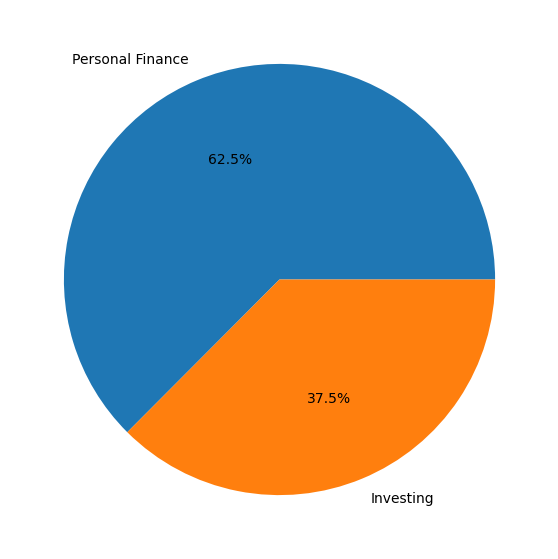

In [7]:
plt.figure(figsize=(7, 7))
plt.pie(data['subreddit'].value_counts(), labels=['Personal Finance', 'Investing'], autopct='%1.1f%%')
plt.savefig('../images/personalfinance_vs_investing.png', dpi=300);

> In the training set, there are a total of 9,460 posts. Among them, 5,915 posts (62.5% of the data) belong to the Personal Finance subreddit, while the remaining 3,545 posts (37.5% of the sample) are from the Investing subreddit.

## Feature engineering

In the following, several features will be created to enhance the understanding of the data and facilitate its analysis. These features include:

- Length of the posts: The total number of characters in each post.
- Number of words: The count of words in each post.
- Average length of words: The average number of characters per word in each post.- Number of sentences: The count of sentences in each post.
- Average number of words per sentence: The average count of words in each sentence of a post.
- Average number of characters per sentence: The average count of characters in each sentence of a post.

By incorporating these features, we can gain valuable insights into the data and develop a more comprehensive understanding of its characteristics.

In [8]:
# This function is imported from nlp_function.py
data = text_feature_engineering(data, 'full_text')
data.head()

,subreddit,full_text,char_length,word_count,mean_word_length,count_sentence,mean_word_per_sentence,mean_char_per_sentence
4615,1,are student loans ever better than paying up f...,409,73,4.602740,4,18.250000,101.250000
2299,1,contractor ghosted us after home repair was do...,2859,525,4.438095,27,19.444444,104.740741
8034,0,i just decentralized the entire $1.4 trillion ...,8490,1445,4.702422,91,15.923077,90.021978
7682,0,1m treasury declines to 3.4% today: discussion...,934,129,6.224806,7,18.428571,132.285714
5622,1,how should i invest my roth ira? \n\ni'm 28 ye...,418,82,4.024390,8,10.250000,50.500000


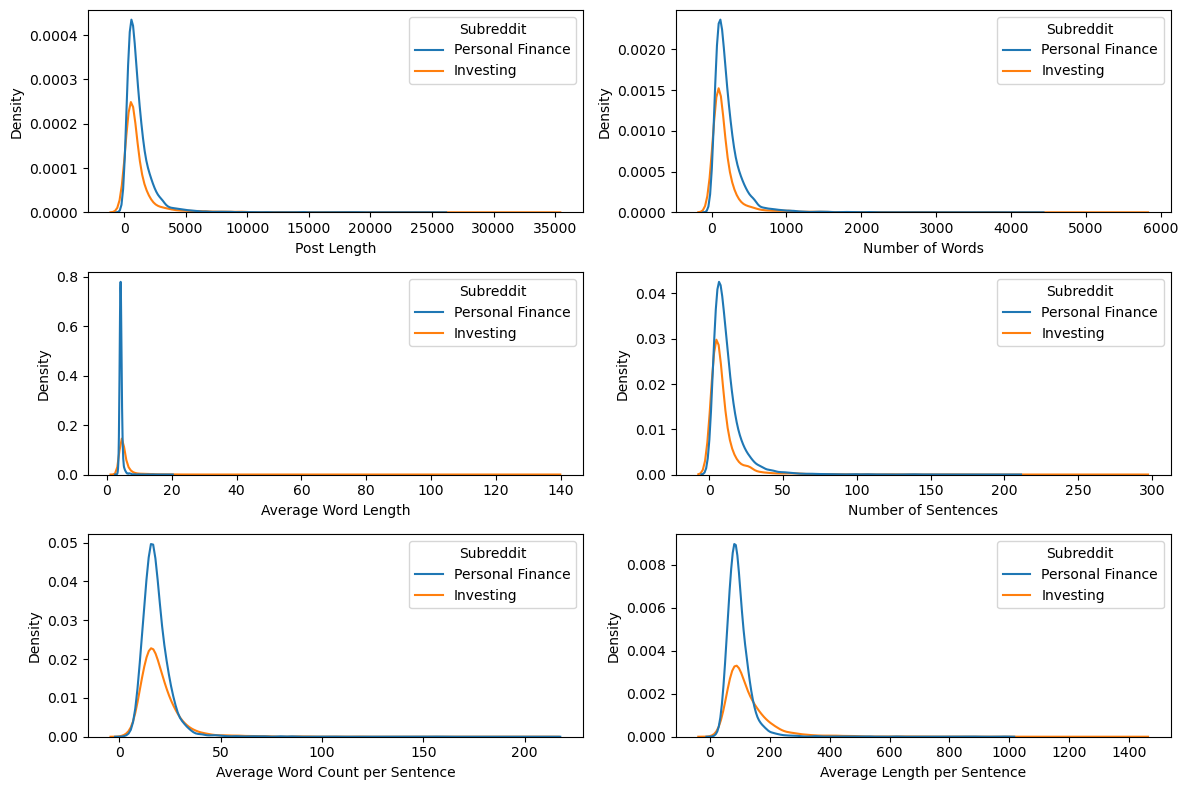

In [9]:
data['Subreddit'] = np.where(data['subreddit']==1, 'Personal Finance', 'Investing')

fig, ax = plt.subplots(3, 2, figsize=(12,8))

sns.kdeplot(data, x='char_length', hue='Subreddit', ax=ax[0, 0])
ax[0, 0].set_xlabel('Post Length')

sns.kdeplot(data, x='word_count', hue='Subreddit', ax=ax[0, 1])
ax[0, 1].set_xlabel('Number of Words')

sns.kdeplot(data, x='mean_word_length', hue='Subreddit', ax=ax[1, 0])
ax[1, 0].set_xlabel('Average Word Length')


sns.kdeplot(data, x='count_sentence', hue='Subreddit', ax=ax[1, 1])
ax[1, 1].set_xlabel('Number of Sentences')

sns.kdeplot(data, x='mean_word_per_sentence', hue='Subreddit', ax=ax[2, 0])
ax[2, 0].set_xlabel('Average Word Count per Sentence')

sns.kdeplot(data, x='mean_char_per_sentence', hue='Subreddit', ax=ax[2, 1])
ax[2, 1].set_xlabel('Average Length per Sentence')

plt.tight_layout()

plt.savefig('../images/char_word_sentence_plot.png', dpi=300);

From the plots above, we can gather interesting observations. In general, the Investing subreddit exhibits a higher number of outlier posts with significantly longer lengths compared to the average. Conversely, the majority of posts in the Personal Finance subreddit have an average word length of less than 5. Although this pattern can also be observed in the Investing subreddit, there is a notable abundance of outliers among its posts. In fact, more than 91% of posts with an average length of 8 belong to the Investing subreddit. Additionally, all 20 posts in the sample with an average word length exceeding 20 are from the Investing subreddit.

Upon closer examination, it becomes apparent that the longer length in many Investing posts can be attributed to the inclusion of links.

#### Posts with High Average Length:

In [10]:
data.loc[data['mean_word_length']> 20, ['subreddit', 'full_text']]

,subreddit,full_text
7105,0,sec charges robinhood $65m where do you think ...
7173,0,google trends for searches like 'stocks' and '...
6681,0,collection of finviz screeners thanks to old p...
6961,0,the market should be more worried about a 'sec...
7151,0,equifax ceo retires https://www.cnbc.com/2017/...
6518,0,neovasc $nvcn anyone that invested in the comp...
6808,0,amazon warehouse workers push to unionize in n...
7026,0,robinhood founders are now billionaires https:...
7357,0,fake meat is 'no laughing matter': plant-based...
6797,0,trump administration bans u.s. investments in ...


In [11]:
data['full_text'][7105]

'sec charges robinhood $65m where do you think rh got $65m to settle with sec? \n\n[https://www.sec.gov/news/press-release/2020-321#:\\\\~:text=robinhood%20agreed%20to%20pay%20%2465%20million%20to%20settle%20the%20charges.&text=despite%20this%2c%20according%20to%20the,beat%20that%20of%20its%20competitors](https://www.sec.gov/news/press-release/2020-321#:~:text=robinhood%20agreed%20to%20pay%20%2465%20million%20to%20settle%20the%20charges.&text=despite%20this%2c%20according%20to%20the,beat%20that%20of%20its%20competitors).'

In [12]:
data.loc[data['mean_word_length']> 8, ['subreddit', 'full_text']]['subreddit'].value_counts(normalize=True)

0    0.915129
1    0.084871
Name: subreddit, dtype: float64

In [13]:
data.loc[data['mean_word_length']> 20, ['full_text']]['full_text']

7105    sec charges robinhood $65m where do you think ...
7173    google trends for searches like 'stocks' and '...
6681    collection of finviz screeners thanks to old p...
6961    the market should be more worried about a 'sec...
7151    equifax ceo retires https://www.cnbc.com/2017/...
6518    neovasc $nvcn anyone that invested in the comp...
6808    amazon warehouse workers push to unionize in n...
7026    robinhood founders are now billionaires https:...
7357    fake meat is 'no laughing matter': plant-based...
6797    trump administration bans u.s. investments in ...
7301    oxycontin maker purdue pharma exploring bankru...
5930    what happen to svspx in mid december 2022? svs...
6859    beyond meat looks to raise $183.8 million in i...
7228    amazon hits $1 trillion market cap [https://ww...
7093    buffet sells his airlines stocks again  [https...
6723    amazon says it will not build a headquarters i...
7050    nasdaq enters bear market https://www.cnbc.com...
7092    china 

> The posts that have a high average length primarily consist of links.

In [14]:
data.loc[data['mean_char_per_sentence']> 150, ['subreddit', 'full_text']]['subreddit'].value_counts(normalize=False)

0    913
1    406
Name: subreddit, dtype: int64

> Similar to average word length, we observe that posts with a high average sentence length are also more commonly found in the `Investing` subreddit.

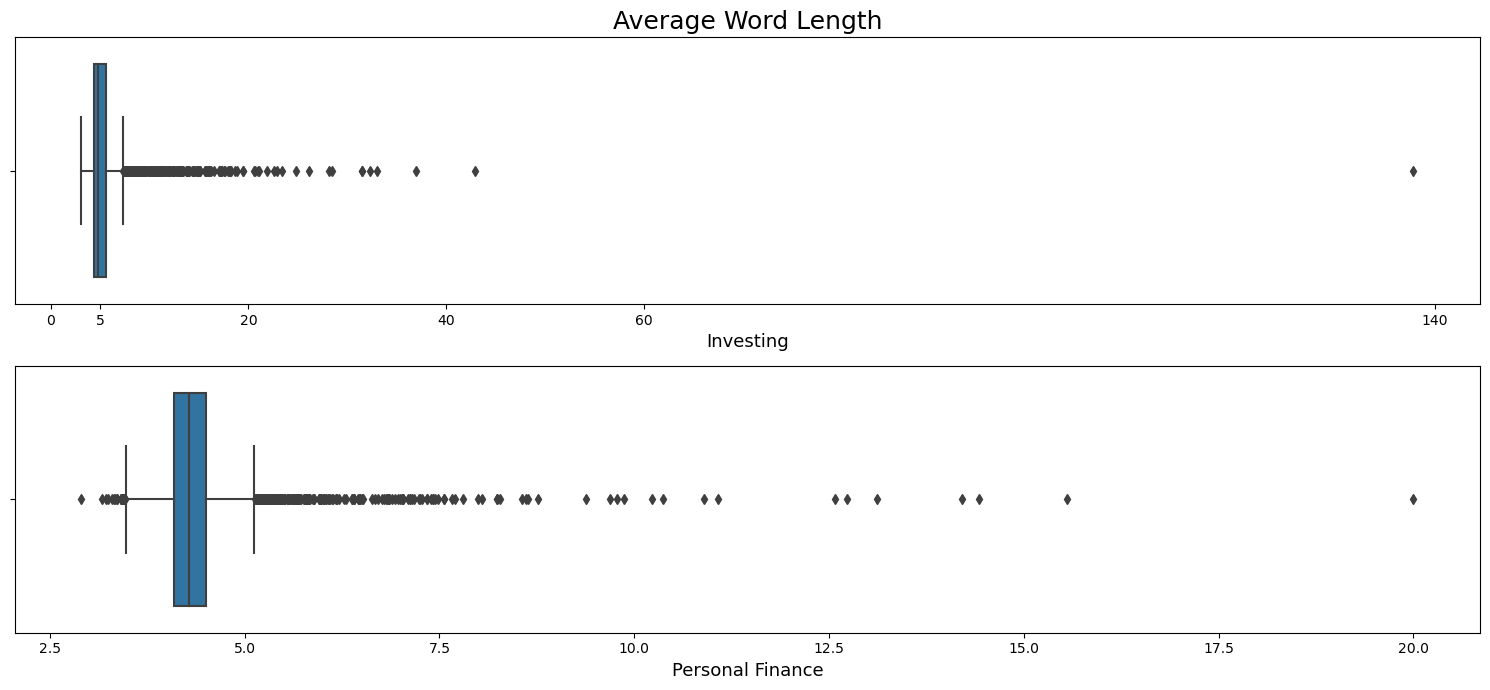

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(15, 7))
sns.boxplot(data[data['subreddit']==0], x='mean_word_length', ax=ax[0])
ax[0].set_xticks(ticks=[0, 5, 20, 40, 60, 140]);
sns.boxplot(data[data['subreddit']==1], x='mean_word_length', ax=ax[1])

ax[0].set_title('Average Word Length', fontdict={'fontsize': 18, 'fontweight':5}, loc='center')
ax[0].set_xlabel('Investing', fontdict={'fontsize': 13})
ax[1].set_xlabel('Personal Finance', fontdict={'fontsize': 13})
plt.tight_layout()
plt.savefig('../images/average_word_length.png', dpi=300);

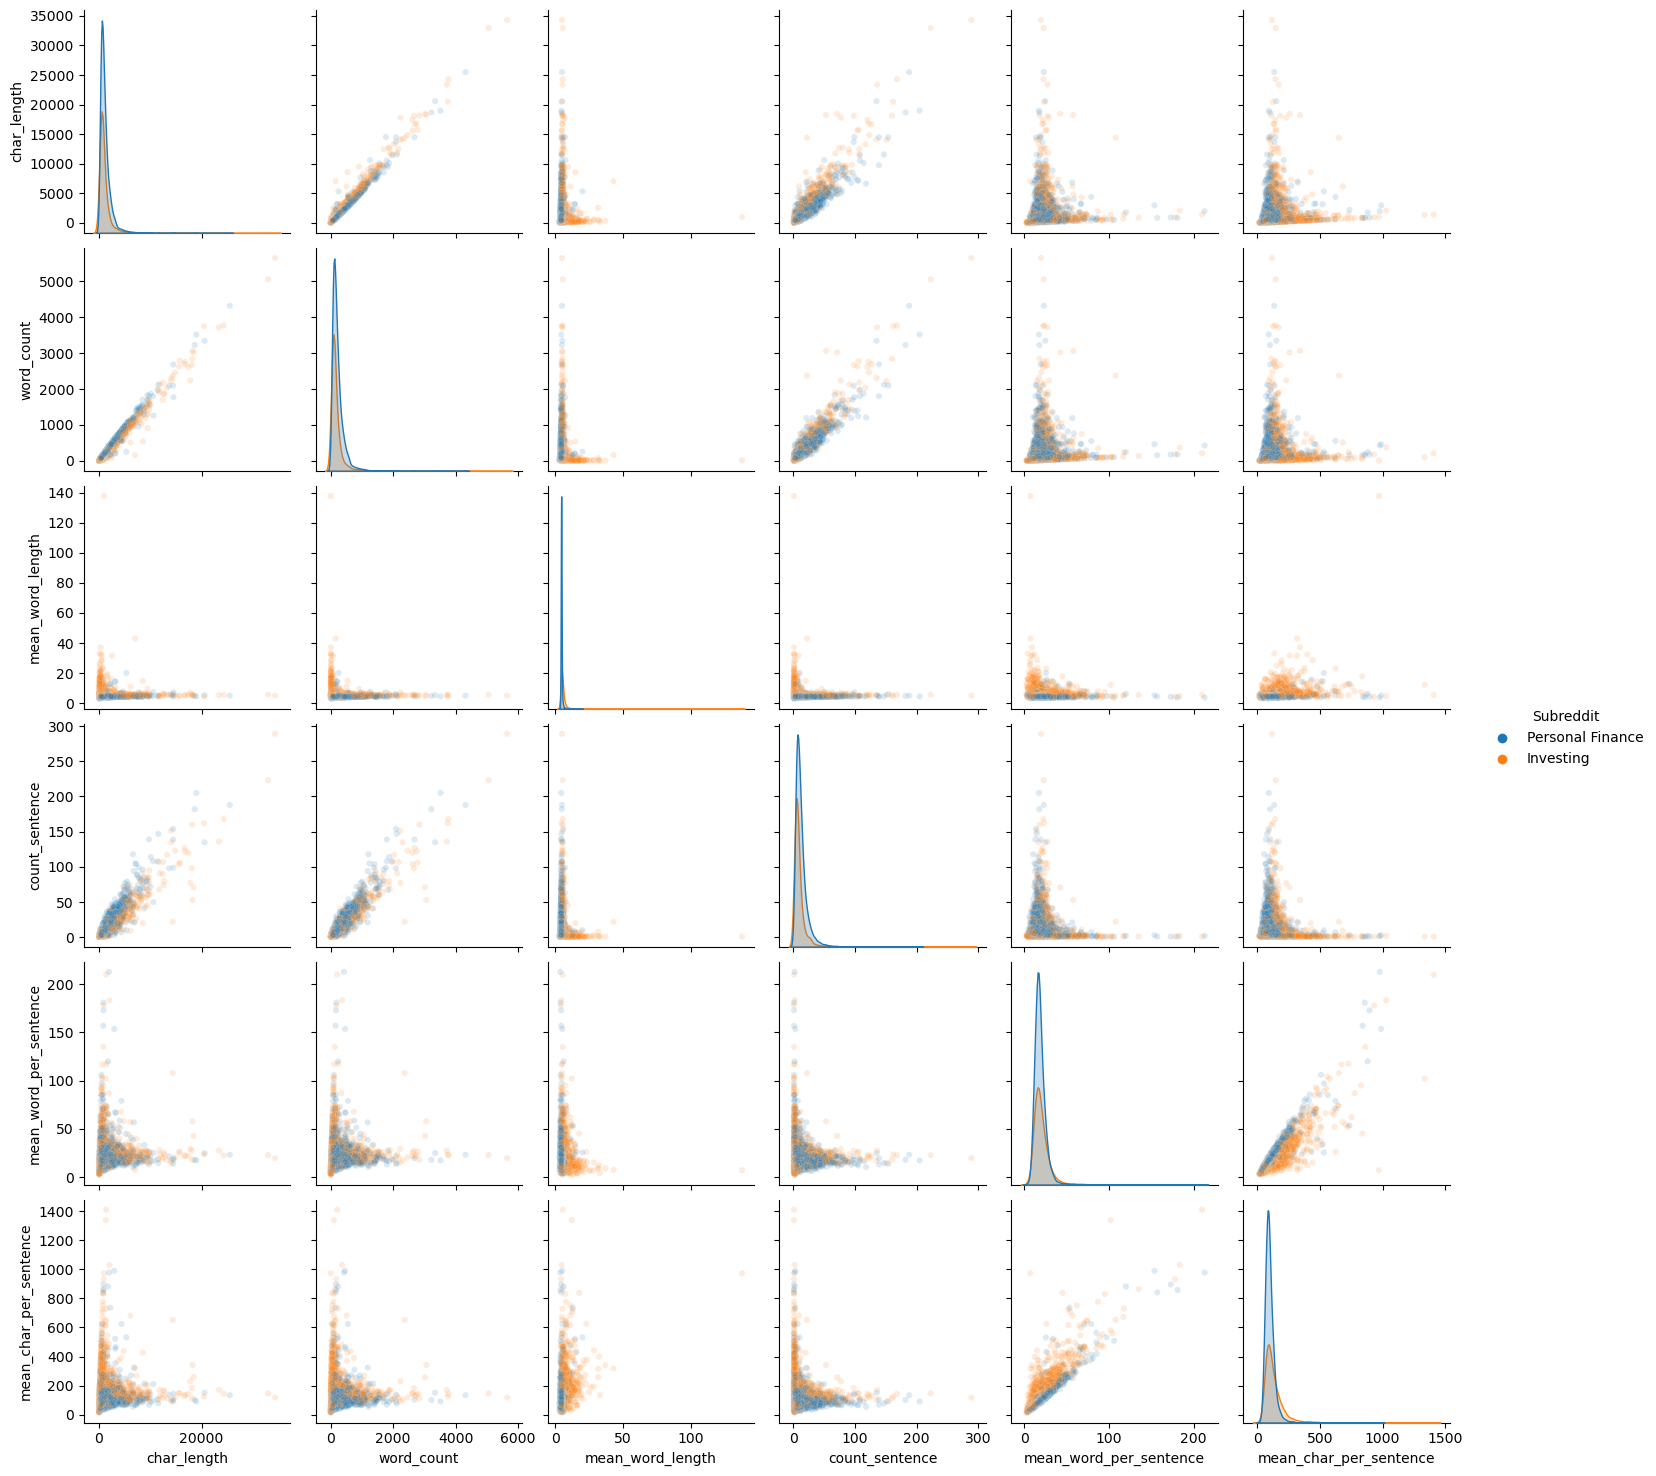

In [16]:
# https://stackoverflow.com/questions/42181317/changing-the-size-of-seaborn-pairplot-markers
features=['char_length', 'word_count', 'mean_word_length', 'count_sentence', 'mean_word_per_sentence','mean_char_per_sentence']

sns.pairplot(data, hue='Subreddit', vars=features, plot_kws={'s': 20, 'alpha':0.15});

## Term Frequency Analysis


Term frequency analysis is a valuable tool in natural language processing (NLP) as it provides insights into the significance and relevance of words within a given document. By calculating the frequency of each term in a text, we can identify the most commonly used words, which often reflect the main themes and topics. 

Howerve, we can proceed to the analysis itself, we need to preprocess the data first. There should not be any missing values, any puctuations, any capital letter or any stopwords. To improve analysis accuracy, an extra preprocessing step has been added: lemmatizing words based on their part of speech. This step normalizes words, reducing them to their base form and considering grammatical context. By doing so, variations are consolidated, enhancing data quality and coherence for more precise insights.

In [17]:
def clean(post):
    """
    Preprocesses a given post by tokenizing, lemmatizing, removing stopwords, and returning the cleaned text.
    
    Parameters:
    - post (str): The input post to be preprocessed.
    
    Returns:
    - cleaned_post (list): A list of cleaned words from the post.
    """
    
    # Tokenize the post
    post = ' '.join(tokenizer.tokenize(post))
    
    # Lemmatize the post based on part of speech
    post = pos_lemmatizer(post)
    
    # Remove stopwords and creates a list of words
    post = [word for word in post.split() if word not in stop_words]
    
    # Return the cleaned post
    return post

In [18]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer('\w+')

data['full_text_cleaned'] = data['full_text'].apply(clean)

In [19]:
def word_count_df(data):
    """
    Generates a word count dataframe from the given data.
    
    Parameters:
    - data (list): A list of posts or texts.
    
    Returns:
    - word_df (DataFrame): A dataframe containing the word count information, sorted by count in descending order.
    """
    
    # Create an empty dictionary to store word counts
    word_dic = {}
    
    # Iterate over each post in the data
    for post in data:
        # Iterate over each word in the post
        for word in post:
            # Update the word count in the dictionary
            if word in word_dic.keys():
                word_dic[word] += 1
            else:
                word_dic[word] = 1
    
    # Convert the word count dictionary to a dataframe
    # Source: https://favtutor.com/blogs/convert-dictionary-to-dataframe-python
    word_df = pd.DataFrame.from_dict(word_dic, orient='index', columns=['count']).reset_index(names='word')
    
    # Sort the dataframe by count in descending order
    word_df = word_df.sort_values('count', ascending=False)
    
    # Return the word count dataframe
    return word_df

In [20]:
word_df = word_count_df(data['full_text_cleaned'])

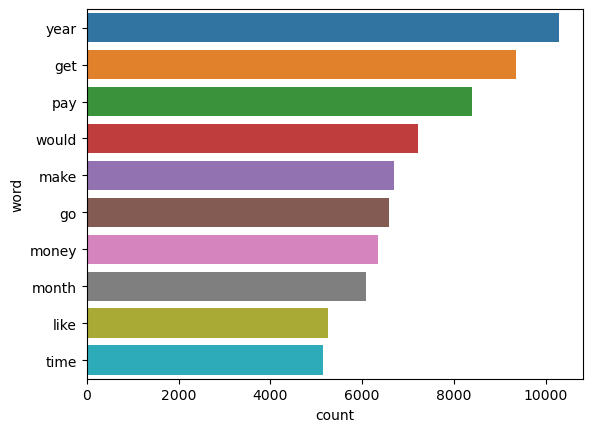

In [21]:
sns.barplot(word_df.head(10), y = 'word', x='count');

> The plot displayed above presents the top 10 words with the highest frequency across the sample. However, for a more informative analysis, it would be beneficial to examine the term frequency within each individual subreddit.

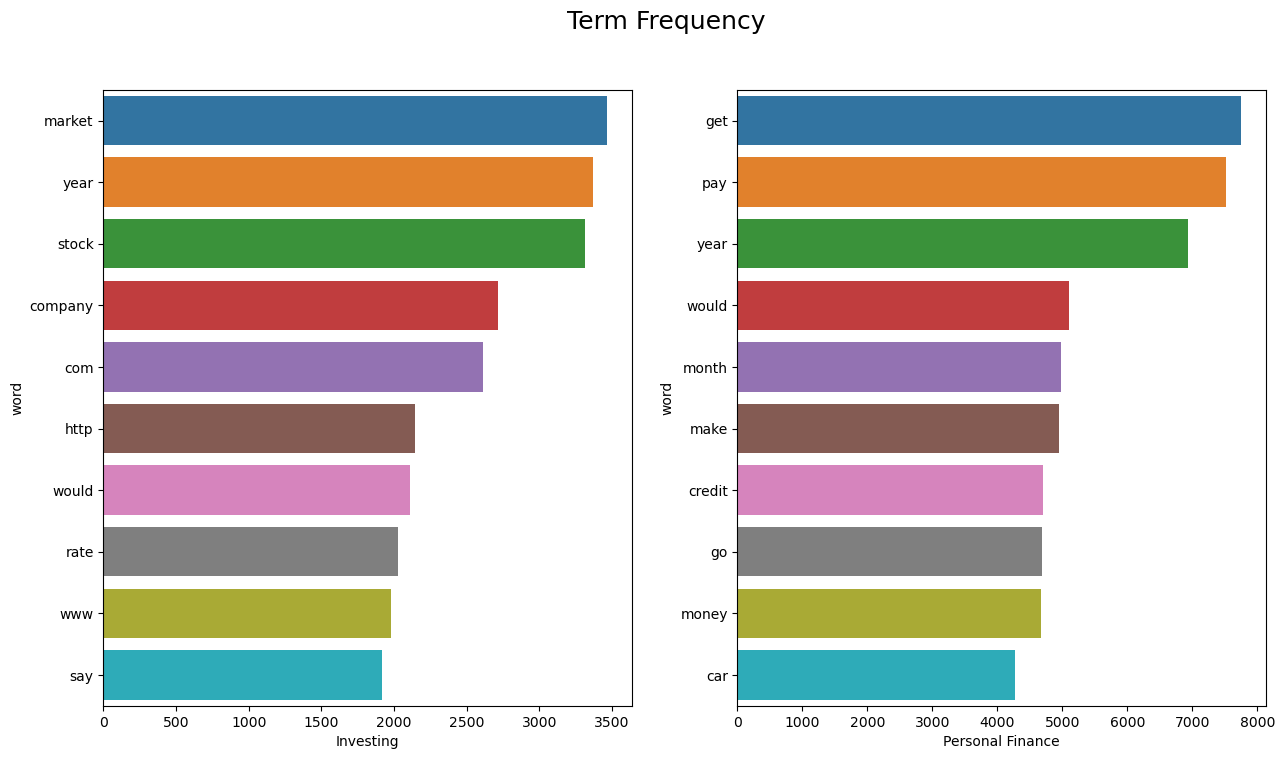

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.barplot(data=word_count_df(data.loc[data['subreddit']==0, 'full_text_cleaned']).head(10), 
            y = 'word', 
            x='count', 
            ax=ax[0]
           )
ax[0].set_xlabel('Investing')
sns.barplot(data=word_count_df(data.loc[data['subreddit']==1, 'full_text_cleaned']).head(10), 
            y = 'word', 
            x='count', 
            ax=ax[1]
           )
ax[1].set_xlabel('Personal Finance')

fig.suptitle('Term Frequency', fontsize=18)

plt.savefig('../images/term_frequency.png', dpi=300);

Upon examining the term frequency between the Investing and Personal Finance subreddits, a notable distinction can be observed in the choice of words used. In the Investing subreddit, words like market, stock, company, rate, com, http, and www are commonly found. These terms are more specific to the realm of investing and reflect discussions related to market analysis, stocks, and investment opportunities. On the other hand, the Personal Finance subreddit frequently employs words such as pay, month, credit, money, and car. These terms align with the focus of personal financial management and encompass topics like budgeting, credit scores, and everyday financial decisions. The variance in word usage aligns logically with the respective subject matters covered within each subreddit, highlighting their distinct areas of discussion.

##  Most Common Words

In addition to analyzing the term frequency of words, it is also valuable to examine the words appearing in each post, as it provides a more comprehensive understanding of the topics being discussed. To carry out this analysis, the Scikit-learn library's CountVectorizer, which is a part of the feature extraction module, is utilized. The CountVectorizer allows for the transformation of text data into a numerical representation by creating a matrix of word frequencies.

In [23]:
cvec = CountVectorizer(stop_words=stopwords.words('english'))
X = cvec.fit_transform(data['full_text'])
df = pd.DataFrame(X.todense(), columns=cvec.get_feature_names_out())

In [24]:
df.sum().sort_values(ascending=False).head(10)

would     7211
money     6352
year      5619
get       5260
like      5187
credit    4937
years     4678
pay       4652
time      4494
car       4102
dtype: int64

In [25]:
df['subreddit'] = data['subreddit']

In [26]:
investing = df.loc[df['subreddit']==0].sum().sort_values(ascending=False).head(10)
personalfinance = df.loc[df['subreddit']==1].sum().sort_values(ascending=False).head(11)[1:] # removing the word subreddit from the list of words.

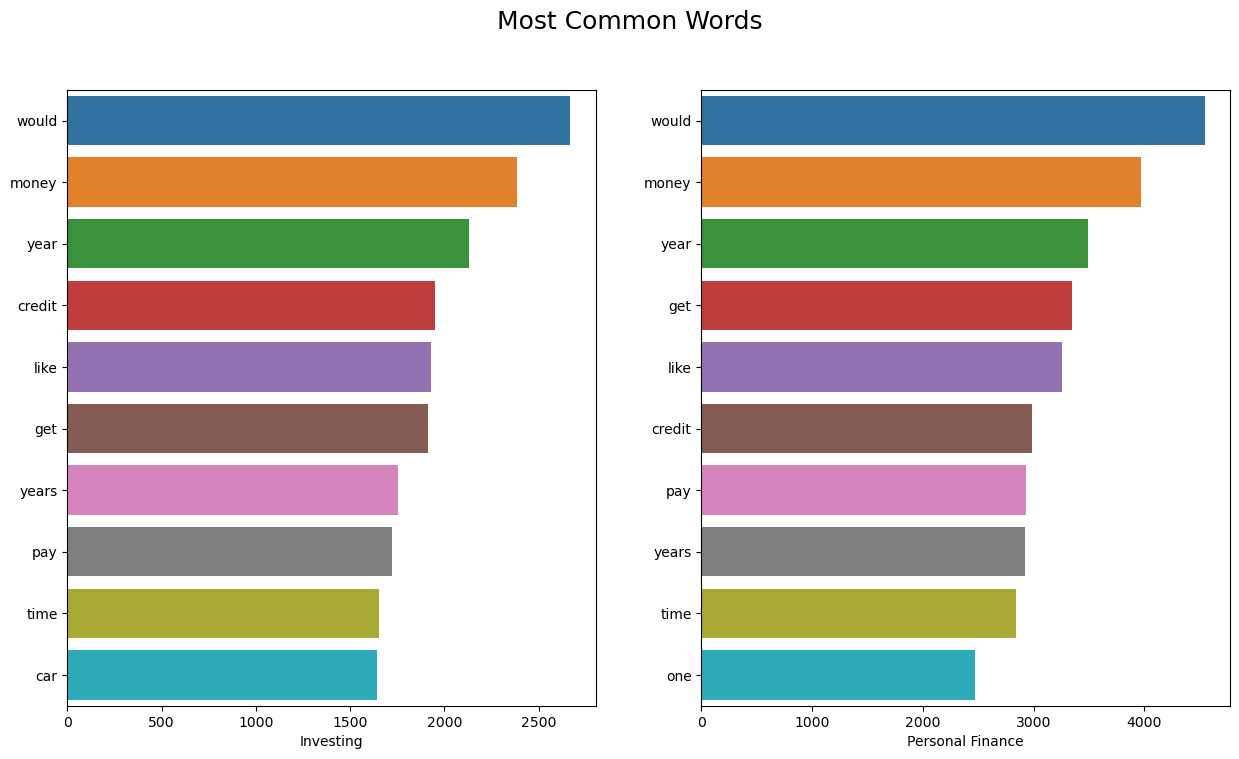

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.barplot( 
            y = investing.index,
            x= investing,
            ax=ax[0]
           )
ax[0].set_xlabel('Investing')

sns.barplot( 
            y = personalfinance.index,
            x= personalfinance,
            ax=ax[1]
           )

ax[1].set_xlabel('Personal Finance')
fig.suptitle('Most Common Words', fontsize=18)
plt.savefig('../images/most_common_words.png', dpi=300);

Upon examining the most commonly appearing words across the two subreddits, it becomes evident that the word choices are remarkably similar, making it challenging to differentiate between the two groups. This finding is intriguing considering that our analysis employs techniques like `CountVectorizer` and `TF-IDFVectorizer` for text preprocessing. These techniques transform text into numerical representations, aiding in feature extraction and analysis. However, it seems that the algorithm may perceive the two subreddits as less distinct than anticipated, based on the similarity of the commonly used words. This suggests that further investigation and fine-tuning of the analysis approach may be necessary to uncover more discernible differences between the subreddits.

## Sentiment Analysis

To conclude this exploratory analysis, an evaluation of the overall sentiment within each subreddit will be conducted. This sentiment analysis will offer valuable insights into the dominant attitudes and emotions expressed in the posts. By capturing the underlying sentiment, whether positive, negative, or neutral, it will shed light on the overall tone of the discussions. This examination of sentiment will provide a deeper understanding of the user sentiments and opinions within each subreddit, contributing to a more comprehensive analysis of the dataset.

In [28]:
sa = SentimentIntensityAnalyzer()

data['sentiment'] = data['full_text'].apply(lambda x: sa.polarity_scores(x)['compound'])

In [29]:
data.shape

(9460, 11)

In [30]:
#https://numpy.org/doc/stable/reference/generated/numpy.select.html
threshold = 0.2
pos_cond = data['sentiment'] > threshold
neg_cond = data['sentiment'] < -threshold

data['sentiment_category'] = np.select([pos_cond, neg_cond], ['positive', 'negative'], 'neutral')
data['sentiment_category'].value_counts()

positive    6620
negative    2189
neutral      651
Name: sentiment_category, dtype: int64

In [31]:
data.pivot_table(
    values= 'count_sentence',
    index= 'subreddit',
    columns= 'sentiment_category',
    aggfunc= 'count', 
    margins=True
)

sentiment_category,negative,neutral,positive,All
subreddit,,,,
0,865,284,2396,3545
1,1324,367,4224,5915
All,2189,651,6620,9460


In [32]:
pd.crosstab(
    index=data['subreddit'], 
    columns= data['sentiment_category'],
    margins=True,
    margins_name='all',
    normalize=True
)

sentiment_category,negative,neutral,positive,all
subreddit,,,,
0,0.091438,0.030021,0.253277,0.374736
1,0.139958,0.038795,0.446512,0.625264
all,0.231395,0.068816,0.699789,1.000000


In [33]:
data.loc[data['subreddit']==0, 'sentiment_category'].value_counts(normalize=True) # investing

positive    0.675882
negative    0.244006
neutral     0.080113
Name: sentiment_category, dtype: float64

In [34]:
data.loc[data['subreddit']==1, 'sentiment_category'].value_counts(normalize=True) # personal finance

positive    0.714117
negative    0.223838
neutral     0.062046
Name: sentiment_category, dtype: float64

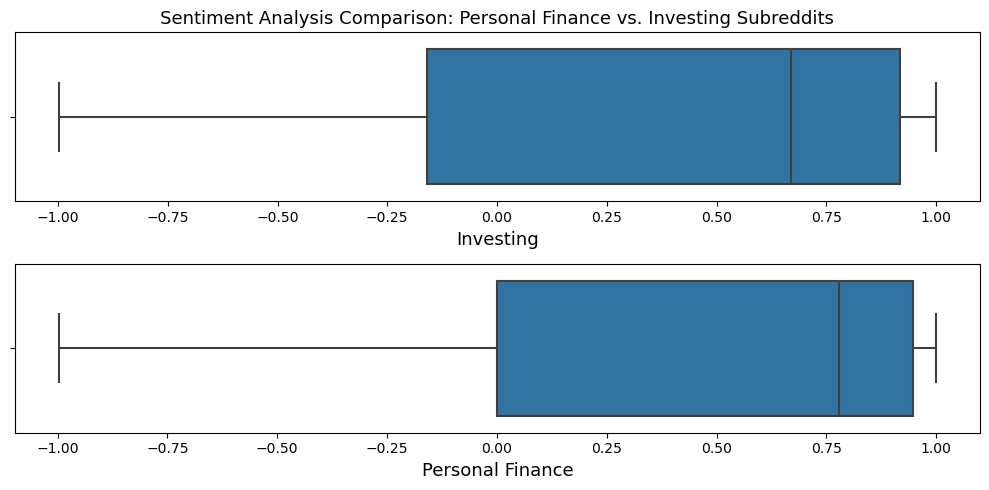

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
sns.boxplot(data[data['subreddit']==0], x='sentiment', ax=ax[0])
sns.boxplot(data[data['subreddit']==1], x='sentiment', ax=ax[1])

ax[0].set_title('Sentiment Analysis Comparison: Personal Finance vs. Investing Subreddits', fontdict={'fontsize': 13}, loc='center')
ax[0].set_xlabel('Investing', fontdict={'fontsize': 13})
ax[1].set_xlabel('Personal Finance', fontdict={'fontsize': 13})
plt.tight_layout()
plt.savefig('../images/sentiment.png', dpi=300);

In [36]:
data_grouped = data.groupby(['subreddit', 'sentiment_category'])['sentiment'].count().reset_index(name='count')
data_grouped['subreddit'] = np.where(data_grouped['subreddit']==0, 'Investing', 'Personal Finance')
data_grouped

,subreddit,sentiment_category,count
0,Investing,negative,865
1,Investing,neutral,284
2,Investing,positive,2396
3,Personal Finance,negative,1324
4,Personal Finance,neutral,367
5,Personal Finance,positive,4224


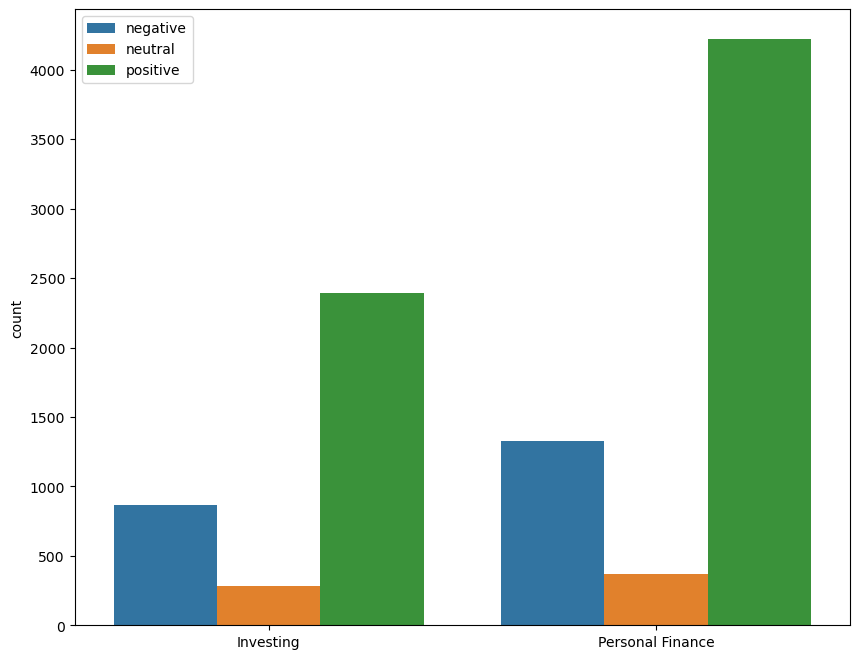

In [37]:
plt.figure(figsize=(10, 8))
sns.barplot(data_grouped, x='subreddit', y = 'count', hue='sentiment_category')
plt.xlabel('')
plt.legend()
plt.savefig('../images/sentiment_per_subreddit', dpi=300);

Among the 9460 posts in the sample, 6620 are categorized as positive, 2189 as negative, and 651 as neutral. It is noteworthy that the personal finance subreddit demonstrates a slightly higher level of positivity in comparison to the investing subreddit. However, these findings indicate that there might not be a substantial need for further exploration as the sentiment across the two subreddits appears to be quite similar.